In [11]:
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi import utils as utils
from sbi.analysis import pairplot
from sbi.inference.base import infer
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# set jupyter configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
default_dpi = mpl.rcParamsDefault["figure.dpi"]
mpl.rcParams["figure.dpi"] = default_dpi * 1.2

import jupyter_black

jupyter_black.load(lab=False)

## Define ballistic throw model

This is the same simulator as in Practical 1 and 2 with a wrapper function to make it compatible with the `sbi` package. 

In [3]:
def throw(
    speed: float,
    angle: int,
    drag: float,
    r: float = 0.050,
    m: float = 0.2,
    h_noise: float = 1.5,
    ρ: float = 1.225,
    g: float = 9.81,
) -> dict:
    """Simulate the throw of a ball.

    Following https://scipython.com/book2/chapter-8-scipy/examples/a-projectile-with-air-resistance/

    Args:
        speed: magnitude of initial speed (m/s).
        angle: launch angle with horizontal (degrees)
        drag: drag coefficient
        r: projectile radius (m)
        m: projectile mass (kg)
        h_noise: std of measurements of altitude (m)
        ρ: air density (default is at sea surface, 15C)
        g: gravitational acceleration (default is average at surface of Earth)

    Returns:
        simulation: simulation results containing distance travelled
            and height as a function of time.
    """

    k = 0.5 * drag * ρ * (np.pi * r**2)  # drag constant, proportional to area

    def deriv(t, u):
        """Return right-hand side of ODE system for the throw."""
        # see diagram at e.g. http://www.physics.smu.edu/fattarus/ballistic.html

        x, v_x, z, v_z = u
        speed = np.hypot(v_x, v_z)
        a_x, a_z = -k / m * speed * v_x, -k / m * speed * v_z - g

        return v_x, a_x, v_z, a_z

    # position and velocity components at launch
    x0, z0 = 0, 0
    rad_angle = np.radians(angle)
    v0_x, v0_z = speed * np.cos(rad_angle), speed * np.sin(rad_angle)

    # integration grid
    t = np.linspace(0, 400, 4000)

    # solve initial value problem (ivp) for distance traveled(t) and height(t)
    # df/dt = f(t,y); f(t_i) = y_i,

    solution = solve_ivp(
        deriv, t_span=(t[0], t[-1]), y0=(x0, v0_x, z0, v0_z), dense_output=True
    )  # dense => continuous solution

    # evaluate solution to obtain distance and height at each time point
    d, _, h, _ = solution.sol(t)

    # the simulator always uses the same time grid, interpolate to the same distance grid
    f = interp1d(d, h, bounds_error=False)
    d_target = np.linspace(0, 150, 100)
    h_target = f(d_target)

    # add noise to make the process stochastic
    x = h_target + h_noise * np.random.randn(d_target.shape[0])

    # to obtain the params from the interactive plot, we need to return parameters here as well
    return dict(θ=(speed, angle, drag, r, m, h_noise, ρ, g), d=d_target, x=x)


def sbi_throw(θ):
    """Wrapper for throw function to work with SBI."""
    speed, angle = θ
    sim = throw(speed, angle, drag=0.13)
    return sim["x"]

## Use Simulation-based Inference to estimate the parameters

We now use the SBI toolbox for finding the optimal parameter. To this end, we define a prior and then use SNPE with 500 simulations.

In [9]:
prior_speed = (10, 70)
prior_angle = (10, 60)

# define the same prior as above with U(low, high), a box in 2 dimensions
prior = utils.BoxUniform(*zip(prior_speed, prior_angle))

# ... and infer the posterior over θ using the sbi toolkit
posterior = infer(sbi_throw, prior, method="SNPE", num_simulations=500)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 190 epochs.


This first cell above just trains the neural density estimator, which we need to evaluate at our observation to obtain a posterior. 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

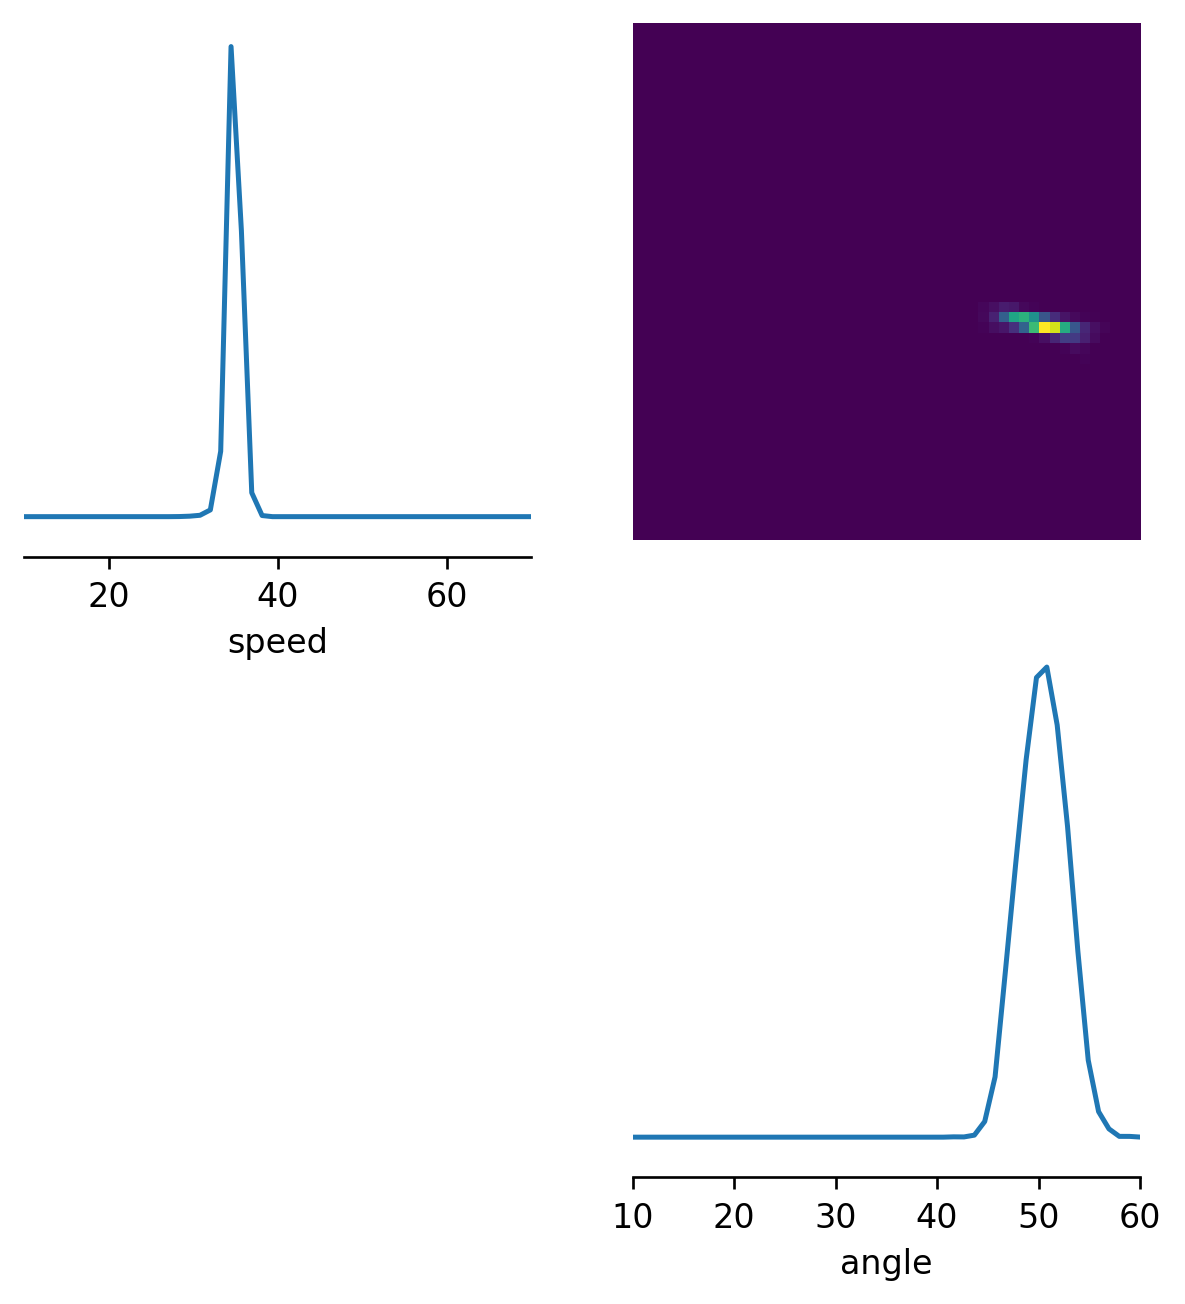

In [14]:
# load the data with unknown parameters
with open("throw-x_o-2.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)

samples = posterior.sample((10000,), x=x_o)
θ = samples.mean(dim=0).numpy()
_ = pairplot(
    samples,
    figsize=(6, 6),
    labels=["speed", "angle"],
    limits=np.array([prior_speed, prior_angle]),
    diag="kde",
    upper="kde",
)

Experiment with the number of simulations you need to obtain a good posterior. Are there other option in SBI that you could use.

The advantage of the amortization is that you can easily evaluate for another case without running all simulations.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

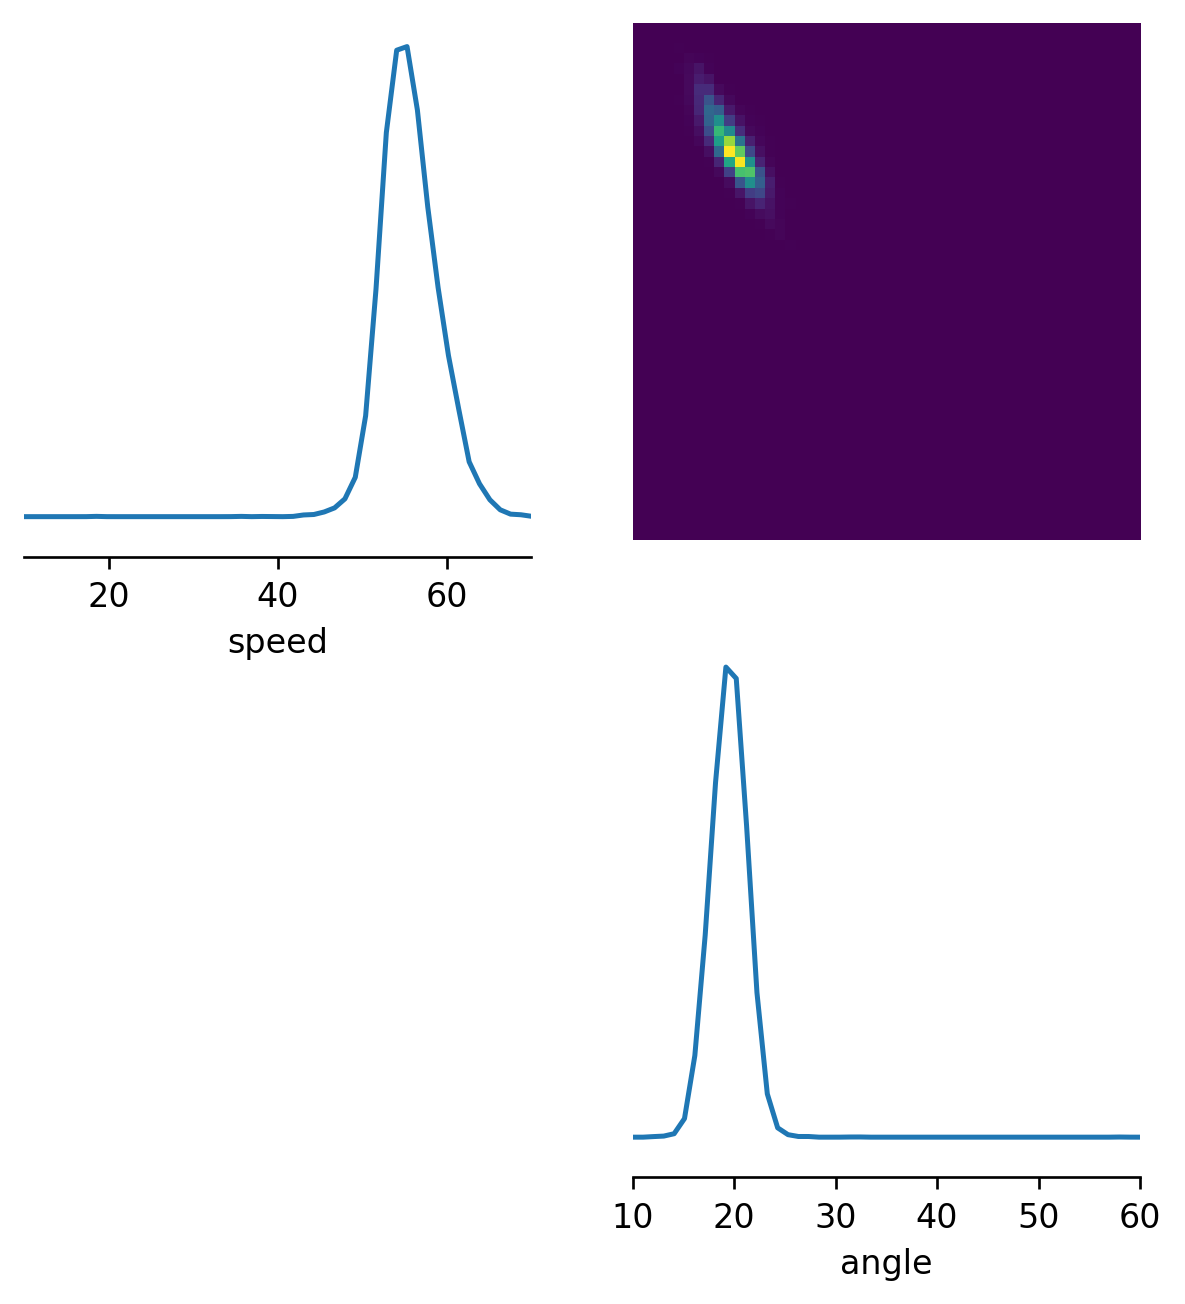

In [15]:
# load another data set with unknown parameters
with open("throw-x_o-3.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)

samples = posterior.sample((10000,), x=x_o)
θ = samples.mean(dim=0).numpy()
_ = pairplot(
    samples,
    figsize=(6, 6),
    labels=["speed", "angle"],
    limits=np.array([prior_speed, prior_angle]),
    diag="kde",
    upper="kde",
)

## Use SBI with summary statistics

We next want to use summary statistics, which allow you to speed up inference or focus on certain aspects of your simulations. We define two summary statistics, the distance at which the ball lands, and the distance at which the ball has its highest point. Implement these functions. Make sure they are always computed, even if the output is not defined (e.g. ball never hits zero in the simulated range). 

In [86]:
def get_landing_distance(d, x_o):
    """Compute distance travelled until projectile hits the ground.
    Args:
        d (array): distance travelled by projectile
        x_o (array): height of projectile at given distance
    Returns:
        Distance traveled in meter until projectile hits ground.
    """
    #### INSERT YOUR CODE HERE ####

    ...
    try:
        ...
    except ValueError:
        landing_dist = float("nan")

    ###############################

    return landing_dist


def get_distance_at_highest_point(d, x_o):
    """Compute distance travelled until projectile reaches highest point.
    Args:
        d (array): distance travelled by projectile
        x_o (array): height of projectile at given distance
    Returns:
        Distance traveled in meter until projectile reaches highest point of its trajectory.
    """

    #### INSERT YOUR CODE HERE ####

    ...

    ###############################
    return dist_at_highest_point


def calculate_summary_statistics(d, x_o):
    """Calculate summary statistics for results in x"""

    return np.array(
        [get_landing_distance(d, x_o), get_distance_at_highest_point(d, x_o)]
    )

We can modify our SBI cell to work with these summary statistics:

In [96]:
def sbi_throw_with_sumstats(θ):
    """Wrapper for throw function to work with SBI."""
    speed, angle = θ.view(-1)
    sim = throw(speed, angle, drag=0.13)

    return torch.from_numpy(calculate_summary_statistics(sim["d"], sim["x"]))

We run SBI again for the same example as above:


In [98]:
prior_speed = (10, 70)
prior_angle = (10, 60)

# define the same prior as above with U(low, high), a box in 3 dimensions
prior = utils.BoxUniform(*zip(prior_speed, prior_angle))

# ... and infer the posterior over θ using the sbi toolkit
posterior = infer(sbi_throw_with_sumstats, prior, method="SNPE", num_simulations=3000)

Running 3000 simulations.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 153 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

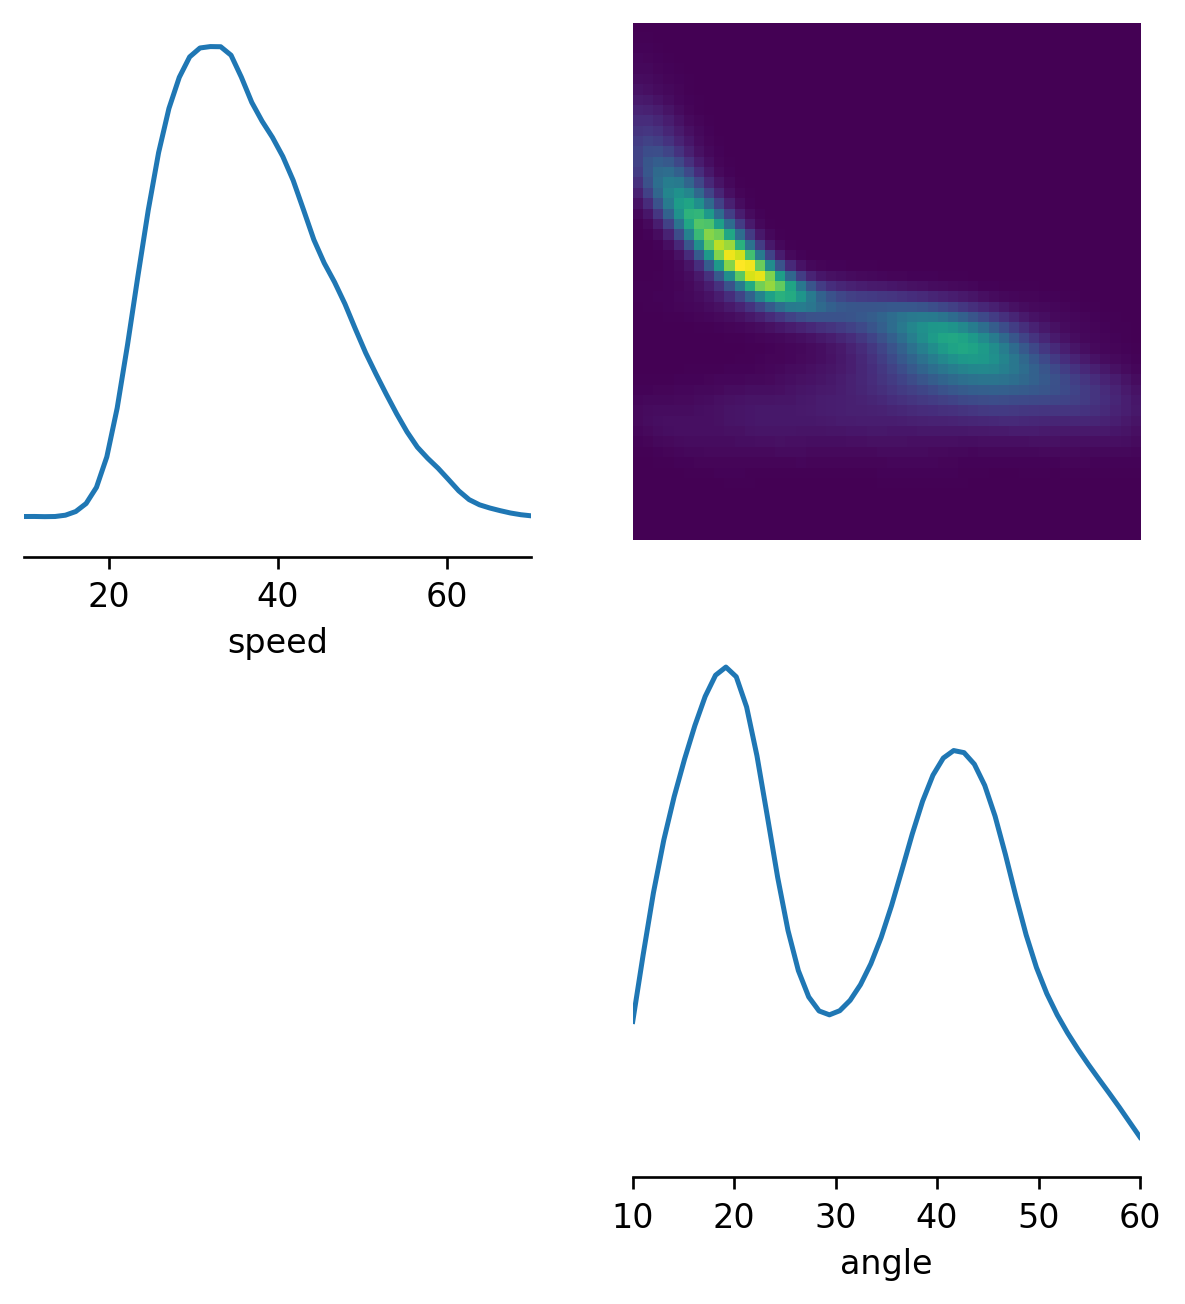

In [99]:
# load the data with unknown parameters
with open("throw-x_o-2.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)
x_o_summary = calculate_summary_statistics(d_o, x_o)

samples = posterior.sample((10000,), x=x_o_summary)
θ = samples.mean(dim=0).numpy()
_ = pairplot(
    samples,
    figsize=(6, 6),
    labels=["speed", "angle"],
    limits=np.array([prior_speed, prior_angle]),
    diag="kde",
    upper="kde",
)

What is different about this posterior? Can you explain why?